In [28]:
#!pip install pystac_client
#!pip install planetary_computer
#!pip install rioxarray
#!pip install torch
#! pip install torchvision

In [1]:
## This script is the updated version for the NAIP image downloading
## The previous version has been deprecated, since Microsoft Updated
## the data storage on Azure and transfered to the Planertory Computer

## https://planetarycomputer.microsoft.com/dataset/naip#Example-Notebook

import os, os.path
from pystac_client import Client
import planetary_computer as pc
import rioxarray
import rasterio as rio
import fiona
import pyproj
from shapely.geometry import shape, Point, Polygon, mapping
from functools import partial
from shapely.ops import transform
import urllib.request
import numpy as np
import geopandas as gpd
import pyproj

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key("st=2022-06-01T22%3A55%3A32Z&se=2022-06-02T23%3A40%3A32Z&sp=rl&sv=2020-06-12&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-06-02T20%3A23%3A33Z&ske=2022-06-09T20%3A23%3A33Z&sks=b&skv=2020-06-12&sig=U5e1SoZGZqIcunum5BKWcmsVi2bmS1tBsr94LPI%2BLoc%3D")
pc.settings.set_subscription_key("st=2022-06-01T22%3A55%3A32Z&se=2022-06-02T23%3A40%3A32Z&sp=rl&sv=2020-06-12&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-06-02T20%3A23%3A33Z&ske=2022-06-09T20%3A23%3A33Z&sks=b&skv=2020-06-12&sig=U5e1SoZGZqIcunum5BKWcmsVi2bmS1tBsr94LPI%2BLoc%3D")

In [53]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [54]:
import fiona

shpfile = '杭州市_市.geojson'

lyr = fiona.open(shpfile)
for feat in lyr:
    area_of_interest_city = feat['geometry']
    # print(area_of_interest)

left, bottom, right, top = lyr.bounds
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [left, bottom],
            [right, bottom],
            [right, top],
            [left, top],
            [left, bottom],
        ]
    ],
}

print(area_of_interest)

{'type': 'Polygon', 'coordinates': [[[118.340264, 29.188879], [120.72549, 29.188879], [120.72549, 30.565097], [118.340264, 30.565097], [118.340264, 29.188879]]]}


In [55]:
## check on GEE, https://code.earthengine.google.com/?scriptPath=Examples%3ADatasets%2FCOPERNICUS%2FCOPERNICUS_S2_SR_HARMONIZED&hl=zh-cn

range_time = '2024-05-01' + '/' + '2024-05-30'

search_new = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=range_time,
    query={"eo:cloud_cover": {"lt": 10}}  
)

items_tiles = search_new.item_collection()

print(f"{len(items_tiles)} Items found in the 'new' range")

6 Items found in the 'new' range


In [56]:
outfolder = 'sentinel-bands-2024'
if not os.path.exists(outfolder): os.makedirs(outfolder)

bands_to_download = ["B02", "B03", "B04", "B08"] # Blue, Green, Red, NIR

for item in items_tiles:
    band_arrays = []

    for band in bands_to_download:
        href = item.assets[band].href
        print(f"Downloading {band} from {href}")
        
        tmp_band_file = os.path.join(outfolder, f"{item.id}_{band}.tif")
        urllib.request.urlretrieve(href, tmp_band_file)

        with rasterio.open(tmp_band_file) as src:
            band_data = src.read(1)  # 读取为 2D 数组
            band_arrays.append(band_data)

            if band == "B02":
                meta = src.meta

        os.remove(tmp_band_file)

    stacked = np.stack(band_arrays, axis=0)  # shape: (4, H, W)

    meta.update(count=4)

    outfilename = os.path.join(outfolder, f"{item.id}_B2B3B4B8.tif")
    with rasterio.open(outfilename, 'w', **meta) as dst:
        dst.write(stacked)

    print(f"Saved 4-band image to {outfilename}")

Saved 4-band image to sentinel-bands-2024\S2B_MSIL2A_20240517T023529_R089_T51RTP_20240517T183705_B2B3B4B8.tif
Saved 4-band image to sentinel-bands-2024\S2B_MSIL2A_20240517T023529_R089_T51RTN_20240517T183348_B2B3B4B8.tif
Saved 4-band image to sentinel-bands-2024\S2B_MSIL2A_20240517T023529_R089_T50RQU_20240517T183510_B2B3B4B8.tif
Saved 4-band image to sentinel-bands-2024\S2B_MSIL2A_20240517T023529_R089_T50RQT_20240517T183530_B2B3B4B8.tif
Saved 4-band image to sentinel-bands-2024\S2B_MSIL2A_20240517T023529_R089_T50RPU_20240517T182848_B2B3B4B8.tif
Saved 4-band image to sentinel-bands-2024\S2B_MSIL2A_20240517T023529_R089_T50RPT_20240517T183252_B2B3B4B8.tif


In [ ]:
#Mosaic tiles

In [5]:
import os, os.path
import numpy as np
import rasterio as rio
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import get_data_window
from rasterio.windows import Window
from rasterio.merge import merge
# optional - turn off warnings
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

In [4]:
# This function is used to mosaic geotiffs in the input folder
# Parameters:
#     dirpath: the folder name of the tif files
#     outfile: the output file of the mosaiced geotiff image

import rasterio
# import ogr
import fiona
import os, os.path
from rasterio.merge import merge
import glob
from shapely.geometry import Polygon
from shapely.geometry import shape


# mosaicRasters(folder, os.path.join(root, 'naip-atlanta.tif'))
inputfolder= 'sentinel-bands-2024'
outfile = 'data/mosacied-naip2024.tif'

# start to mosaic the raster tiles
tiflist = []

for file in os.listdir(inputfolder):    
    if file.endswith('.tif'):
        tiffile = os.path.join(inputfolder, file)
        tiflist.append(tiffile)


src_files_to_mosaic = []
for fp in tiflist:
    try:
        tile_src = rasterio.open(fp)
        tile_bounds = tile_src.bounds
        
        src_files_to_mosaic.append(tile_src)
    except:
        continue

print('The number of mosaiced tiles is:', len(src_files_to_mosaic))

# the method can be set as min, max..
mosaic, out_trans = merge(src_files_to_mosaic) #, method='max'
print('You have mosaiced the results')


# Prepare the schema of the output mosacied image
out_meta = tile_src.meta.copy()
out_meta.update({"driver": "GTiff",
                  "height": mosaic.shape[1],
                  "width": mosaic.shape[2],
                  "transform": out_trans, 
                  "compress": 'lzw',
                  'BIGTIFF': 'YES'
                  }
               )

#out_fp = os.path.join(dirpath, 'atlanta-naip.tif')
with rasterio.open(outfile, "w", **out_meta) as dest:
     dest.write(mosaic)

The number of mosaiced tiles is: 6
You have mosaiced the results


In [2]:
# Clip into Hangzhou
import fiona
import rasterio
from rasterio.mask import mask
from fiona.transform import transform_geom

input_value_raster = 'data/mosacied-naip2024.tif'
shpfile = '杭州市_市.geojson'
out_raster = 'data/hz-naip2024.tif'

with rasterio.open(input_value_raster) as src:
    raster_crs = src.crs.to_string()  # e.g., 'EPSG:32650'

    # reprojection
    with fiona.open(shpfile, "r") as shapefile:
        shapefile_crs = shapefile.crs['init'] if 'init' in shapefile.crs else shapefile.crs_wkt
        shapes = [
            transform_geom(shapefile_crs, raster_crs, feature["geometry"])
            for feature in shapefile
        ]

        out_image, out_transform = mask(src, shapes, crop=True)
        out_meta = src.meta.copy()

out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform,
    "compress": 'lzw'
})

with rasterio.open(out_raster, "w", **out_meta) as dest:
    dest.write(out_image)

In [43]:
# clip into tiles for label

In [6]:
lu_dataset = rasterio.open('data/hz-naip2024.tif')
outfolder = 'data/naip-tiles2024'
if not os.path.exists(outfolder):
    os.mkdir(outfolder)


lu_img = lu_dataset.read()

# height and width of the raster
height, width = lu_dataset.shape

# split the large raser into number of tiles, tile size is 2000*2000
tile_width = 256
tile_height = 256

tile_num_col = int(width/tile_width) + 1
tile_num_row = int(height/tile_height) + 1

# the output folder
if not os.path.exists(outfolder): os.mkdir(outfolder)

# create each tile
for i in range(tile_num_row - 1):
    # loop each column
    for j in range(tile_num_col - 1):
        print('The i and j is:', i, j)
        tilename = os.path.join(outfolder, 'row%s-col%s.tif'%(i, j))
        
        row_start = i*tile_height
        col_start = j*tile_width
        row_end = (i + 1)*tile_height
        col_end = (j + 1)*tile_width
        
        # deal with the right boundary
        if row_end > height - 1: tile_height = height - row_start
        if col_end > width - 1: tile_width = width - col_start
        
        # window = get_data_window(lu_dataset.read(1, masked=True))
        window = Window(col_off=col_start, row_off=row_start, width=tile_width, height=tile_height)

        #filter nodata
        data = lu_dataset.read(window=window)
        if np.all(data == 0):
            print(f"Skip empty tile: row{i}-col{j}")
            continue 
            
        kwargs = lu_dataset.meta.copy()
        kwargs.update({
            'height': window.height,
            'width': window.width,
            'transform': rasterio.windows.transform(window, lu_dataset.transform)})
        
        with rasterio.open(tilename, 'w', **kwargs) as dst:
            dst.write(lu_dataset.read(window=window))

The i and j is: 0 0
Skip empty tile: row0-col0
The i and j is: 0 1
Skip empty tile: row0-col1
The i and j is: 0 2
Skip empty tile: row0-col2
The i and j is: 0 3
Skip empty tile: row0-col3
The i and j is: 0 4
Skip empty tile: row0-col4
The i and j is: 0 5
Skip empty tile: row0-col5
The i and j is: 0 6
Skip empty tile: row0-col6
The i and j is: 0 7
Skip empty tile: row0-col7
The i and j is: 0 8
Skip empty tile: row0-col8
The i and j is: 0 9
Skip empty tile: row0-col9
The i and j is: 0 10
Skip empty tile: row0-col10
The i and j is: 0 11
Skip empty tile: row0-col11
The i and j is: 0 12
Skip empty tile: row0-col12
The i and j is: 0 13
Skip empty tile: row0-col13
The i and j is: 0 14
Skip empty tile: row0-col14
The i and j is: 0 15
Skip empty tile: row0-col15
The i and j is: 0 16
Skip empty tile: row0-col16
The i and j is: 0 17
Skip empty tile: row0-col17
The i and j is: 0 18
Skip empty tile: row0-col18
The i and j is: 0 19
Skip empty tile: row0-col19
The i and j is: 0 20
Skip empty tile: ro

In [ ]:
# 0-greenland
# 1-water
# 2-farmland
# 3-village
# 4-public buildings
# 5-housing
# 6-industry

In [35]:
import torch
import torch.nn as nn
import os
import numpy as np
import rasterio
from rasterio.windows import Window
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

# 定义UNet模型结构
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        
        # 编码部分
        self.conv1 = nn.Sequential(
            nn.Conv2d(n_channels, 32, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # 解码部分
        self.upconv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        self.upconv2 = nn.Sequential(
            nn.Conv2d(128, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        self.upconv1 = nn.Sequential(
            nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(2),
            nn.ReLU(),
            nn.ConvTranspose2d(2, 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
    
    def forward(self, x):
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        
        up3 = self.upconv3(enc3)
        up2 = self.upconv2(torch.cat([up3, enc2], 1))
        up1 = self.upconv1(torch.cat([up2, enc1], 1))
        
        return up1


In [23]:
# 加载训练好的模型权重，并将模型加载到 CPU 上
model.load_state_dict(torch.load('unet_build_model100epc_aug.pth', map_location=torch.device('cpu')))

# 设置模型为评估模式
model.eval()

UNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kerne

In [39]:
# Initialize and load the model
model = UNet(n_channels=3, n_classes=2)  # 假设输入通道是3，输出通道是2
model_path = 'unet_build_model100epc_aug.pth'
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))  # Ensure map_location is set
model.eval()

# 图像预处理和转换成Tensor
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Ensure image is RGB
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert image to Tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet or similar models
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

# 预测并保存结果
def predict_and_save(model, img_path, outfolder, i, j):
    image_tensor = preprocess_image(img_path)
    with torch.no_grad():
        pred = model(image_tensor)
    
    # 获取预测结果并转换为numpy格式以便保存为图片
    pred_mask = pred.argmax(dim=1).squeeze().cpu().numpy()
    
    # 保存预测结果为新TIFF文件
    out_filename = os.path.join(outfolder, f'prediction_row{i}-col{j}.tif')
    with rasterio.open(img_path, 'r') as src:
        meta = src.meta
        meta.update({'count': 1})  # 只有1个波段用于预测掩膜

        with rasterio.open(out_filename, 'w', **meta) as dst:
            dst.write(pred_mask, 1)  # 将预测的掩膜写入文件

# 遍历图像文件，预测并保存结果
base_path = Path('data/naip-tiles2024')
img_dir = base_path
outfolder = 'data/predictions2024'
if not os.path.exists(outfolder):
    os.mkdir(outfolder)

tile_num_col = 5  # 每行的块数（根据你的实际需求调整）
tile_num_row = 5  # 每列的块数（根据你的实际需求调整）

# 遍历图像文件并进行预测
for i, img_file in enumerate(img_dir.iterdir()):
    if not img_file.is_dir():
        print(f"Processing {img_file.name}")
        
        # 预测并保存
        predict_and_save(model, img_file, outfolder, i // tile_num_col, i % tile_num_col)  # 使用 i 来作为行列索引命名


Processing row0-col0.tif
Processing row0-col1.tif
Processing row0-col2.tif
Processing row0-col3.tif
Processing row1-col0.tif
Processing row1-col1.tif
Processing row1-col2.tif
Processing row1-col3.tif
Processing row2-col0.tif
Processing row2-col1.tif
Processing row2-col2.tif
Processing row2-col3.tif
Processing row3-col0.tif
Processing row3-col1.tif
Processing row3-col2.tif
Processing row3-col3.tif
Processing row4-col0.tif
Processing row4-col1.tif
Processing row4-col2.tif
Processing row4-col3.tif
Processing row5-col0.tif
Processing row5-col1.tif
Processing row5-col2.tif
Processing row5-col3.tif
Processing row6-col0.tif
Processing row6-col1.tif
Processing row6-col2.tif
Processing row6-col3.tif


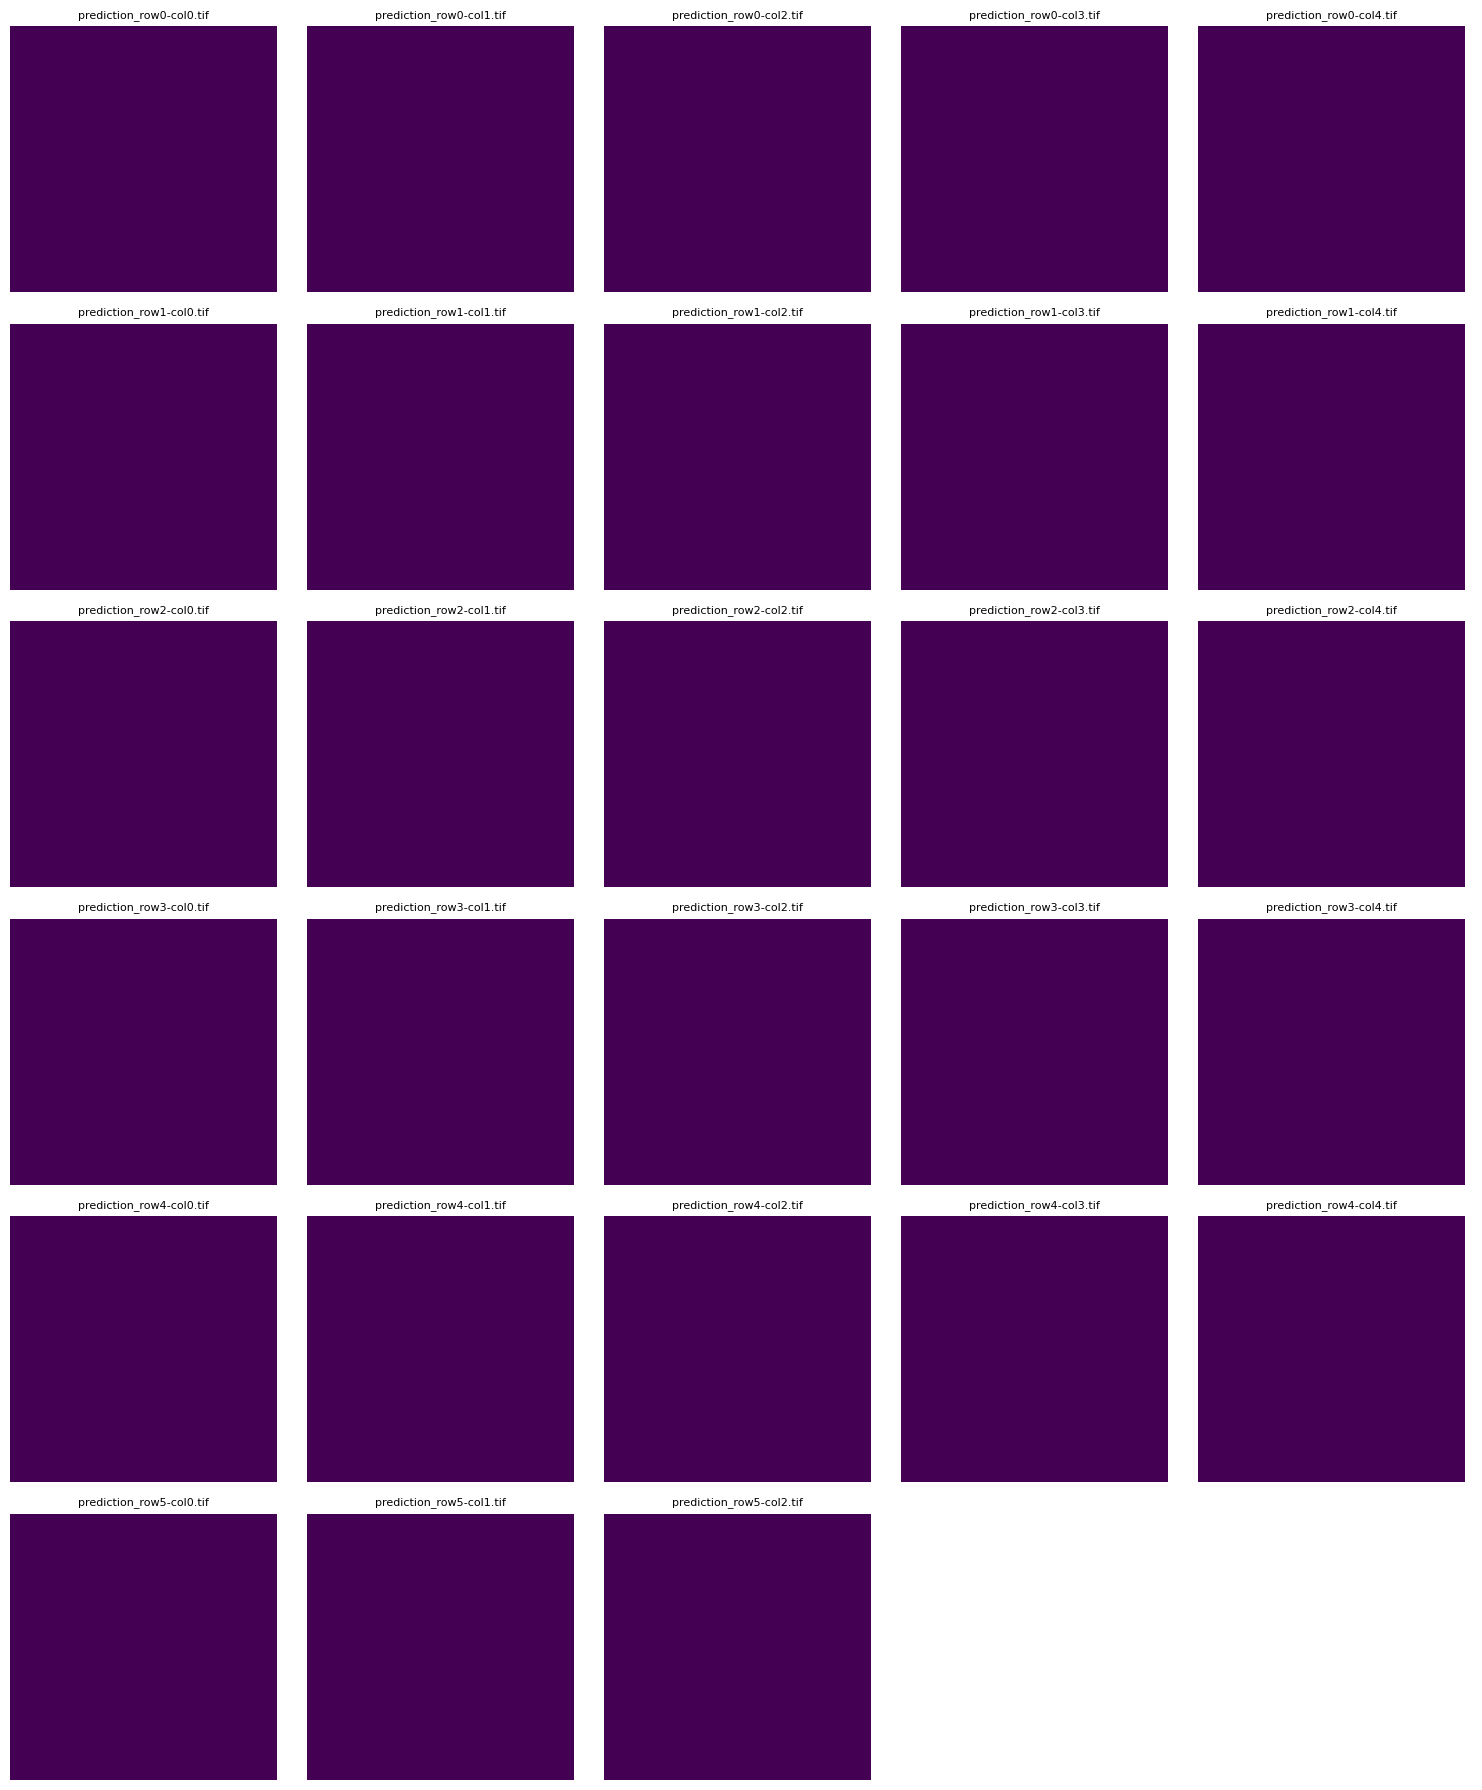

In [41]:
import os
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# 设置预测图像所在路径
pred_folder = Path("data/predictions2024")
pred_images = list(pred_folder.glob("*.tif"))

# 设置展示网格的行列数（可按需要改）
num_cols = 5
num_rows = (len(pred_images) + num_cols - 1) // num_cols

# 设置图像大小
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

for idx, img_path in enumerate(pred_images):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    img = Image.open(img_path)
    ax.imshow(img, cmap='viridis')
    ax.set_title(img_path.name, fontsize=8)
    ax.axis("off")

# 如果图像不足填满整个 grid，则关闭多余子图
for idx in range(len(pred_images), num_rows * num_cols):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.axis("off")

plt.tight_layout()
plt.show()
